# Classifying Tree Leaves
> May 29, 2018

<img src="img/leaves.png" style="float:left;max-height:300px;border:0px solid black">

This is a pipeline from preprocessing tree leaf images to building a predictive model to recognize them.

---

## Contents

1. **Data Preproccessing**
    1. Import
    2. Uniformization
    3. Augmentation
    4. Visualization
    5. Formatting
2. **Convolutional Neural Network**
    1. Achitecture
    2. Model Training
    3. Model Evaluation
---

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
import os

In [2]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Concatenate

Using TensorFlow backend.


In [5]:
SIZE = 128
LABELS = 99
CHANNELS = 1

---
## 1. - Data Preproccessing

### 1.1 - Data Import
The leaf dataset is proveded by [Kaggle](https://www.kaggle.com/). It consists of two parts: 
1. A training and testing csv of features that define the margin, shape, texture of the images. 
2. A set of jpg-files with various resolutions, one for every image in the train and test set.

In this notebook, I will only make use of the images for training. I do import the training features, however, to gather the image id's and labels.

In [98]:
train = pd.read_csv("/Users/desiredewaele/Google Drive/Databases/Leaves/train.csv")
train.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


---
### 1.2 - Data Uniformization
By retrieving the filenames, I can import and uniformize the images in one for loop. The steps are:
* Import with open computer vision
* Padding to square images
* Rescaling them to a resolution of 128x128.

In [101]:
path = "./"
path = "/Users/desiredewaele/Google Drive/Databases/Leaves/images/"

filenames = train.id.apply(lambda x: str(x)+".jpg").values
images = []
for f in filenames:
    image = cv.imread(path+f)
    image = image[...,[0]]
    x, y, _ = image.shape
    width = np.abs(int((x-y) / 2))
    if x > y: image = np.pad(image, ((0,0), (width, width), (0,0)), 'constant')
    else: image = np.pad(image, ((width, width), (0,0), (0,0)), 'constant')
    image = cv.resize(image, (SIZE, SIZE), interpolation=cv.INTER_LINEAR)
    image = np.expand_dims(image, 0)
    images.append(image)
data = np.concatenate(images)
print("Shape of imported data:", data.shape)

Shape of imported data: (990, 128, 128)


---
### 1.3 - Data Augmentation
We now have 990 images of size 128x128. By looping over the images, we can easily augment the data by:
* Adding 15° rotations to the dataset.
* Per rotation, add its mirror to the dataset.

In [147]:
rotatedImages, flippedImages = [], []
for rotation in np.arange(0, 360, 15):
    for image in data:
        x, y = image.shape
        matrix = cv.getRotationMatrix2D((x/2, y/2), rotation, 1)
        rotImg = cv.warpAffine(image, matrix, (SIZE, SIZE))
        rotatedImages.append(np.expand_dims(rotImg, 0))
        flipImg = cv.flip(rotImg, 1)
        flippedImages.append(np.expand_dims(flipImg, 0))
tensor = np.concatenate(rotatedImages + flippedImages)
tensor.shape

(47520, 128, 128)

In [148]:
labels = pd.concat((train.species for _ in range(48))).reset_index(drop=True)
labels.tail()

47515    Magnolia_Salicifolia
47516             Acer_Pictum
47517      Alnus_Maximowiczii
47518           Quercus_Rubra
47519          Quercus_Afares
Name: species, dtype: object

---
### 1.4 - Data Visualization
Let's now visualize what we got. Seven random leaves are ploted each with their three next rotations.

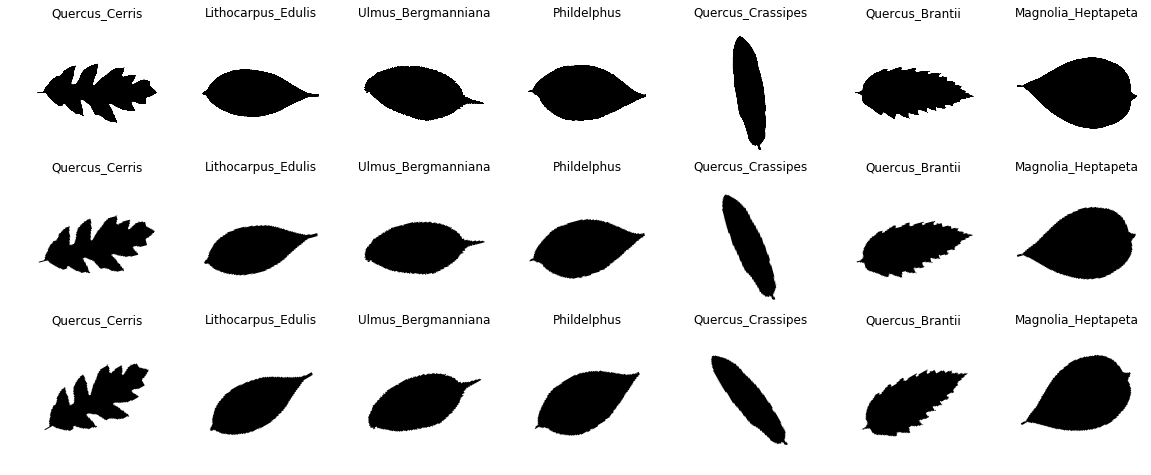

In [149]:
fig, ax = plt.subplots(3, 7, figsize = (20, 8))
for j in range(7):
    x = np.random.randint(0, len(data))
    for i in range(3):
        index = x+(i*len(data))
        ax[i,j].matshow(tensor[index,:,:], cmap=cm.gray_r)
        ax[i,j].set_title("{}".format(labels[index]))
        ax[i,j].axis('off')
plt.show()

---
### 1.5 - Data Formatting
Some final steps are needed to feed them in a convolution network:
* Adding a channel dimension for the images, even though our images are black and white. Keras needs this.
* One-hot encode our labels to arrays of length 99.
* Cut aside a validation set to optimalize our hyperparameters.

In [150]:
print('Data set: {} '.format(tensor.shape))
print('Labels: {} '.format(labels.shape))

Data set: (47520, 128, 128) 
Labels: (47520,) 


In [190]:
tensor = np.reshape(tensor, tensor.shape + (1,))
target = pd.get_dummies(pd.DataFrame(labels)).values
targetLabels = [x[8:] for x in pd.get_dummies(pd.DataFrame(labels)).columns.values]

In [152]:
print('Tensor Shape: {} '.format(tensor.shape))
print('Target Shape: {} '.format(target.shape))

Tensor Shape: (47520, 128, 128, 1) 
Target Shape: (47520, 99) 


In [153]:
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(tensor, target, test_size=0.1, random_state=100)

In [154]:
print('Training set:   {} {}'.format(trainX.shape, trainY.shape))
print('Validation set: {} {}'.format(validX.shape, validY.shape))

Training set:   (42768, 128, 128, 1) (42768, 99)
Validation set: (4752, 128, 128, 1) (4752, 99)


---
## 2. - Convolutional Neural Network
After some iterations, these hyperparameters look like they work well.

In [32]:
BATCHSIZE = 1024
NUMFILTERS = 16
FILTER = 3
EPOCHS = 50
CHANNELS = 1

---
### 2.1 - Architecture
We choose an architecture with three onculutional layers. Each one is shrinked down by max-pooling. Howeve, the depth increases. Next, we add two dense layers, accompanied by dropouts and activations.

In [33]:
model = Sequential([
    Conv2D(NUMFILTERS, (FILTER, FILTER), padding='same', activation='tanh', input_shape=(SIZE, SIZE, CHANNELS)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(NUMFILTERS*2, (FILTER, FILTER), padding='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(NUMFILTERS*3, (FILTER, FILTER), padding='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(LABELS*4, activation='tanh'),
    Dropout(0.5),
    Dense(LABELS, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

This great Keras feature sumarizes our model.

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12288)             0         
__________

---
### 2.2 - Model Training
I trained this model on [Colab](https://colab.research.google.com).

In [23]:
history = convolutionalModel.fit(trainX, trainY, BATCHSIZE, EPOCHS, validation_data=(validX, validY))

Train on 42768 samples, validate on 4752 samples
Epoch 1/50
42768/42768 [==============================] - 31s 723us/step - loss: 3.2987 - acc: 0.1573 - val_loss: 2.1387 - val_acc: 0.4181
Epoch 2/50
42768/42768 [==============================] - 24s 573us/step - loss: 2.2073 - acc: 0.3517 - val_loss: 1.6255 - val_acc: 0.5347
Epoch 3/50
42768/42768 [==============================] - 25s 573us/step - loss: 1.7547 - acc: 0.4645 - val_loss: 1.3218 - val_acc: 0.6080
Epoch 4/50
42768/42768 [==============================] - 25s 574us/step - loss: 1.4626 - acc: 0.5391 - val_loss: 1.1074 - val_acc: 0.6759
Epoch 5/50
42768/42768 [==============================] - 25s 574us/step - loss: 1.2418 - acc: 0.6052 - val_loss: 0.9354 - val_acc: 0.7229
Epoch 6/50
10240/42768 [======>.......................] - ETA: 17s - loss: 1.1072 - acc: 0.640642768/42768 [==============================] - 25s 574us/step - loss: 1.0828 - acc: 0.6492 - val_loss: 0.8675 - val_acc: 0.7330
Epoch 7/50
42768/42768 [=========

---
### 2.3 Model Evaluation
Let's plot the accuracy and loss on both the training and validation set, during training time.

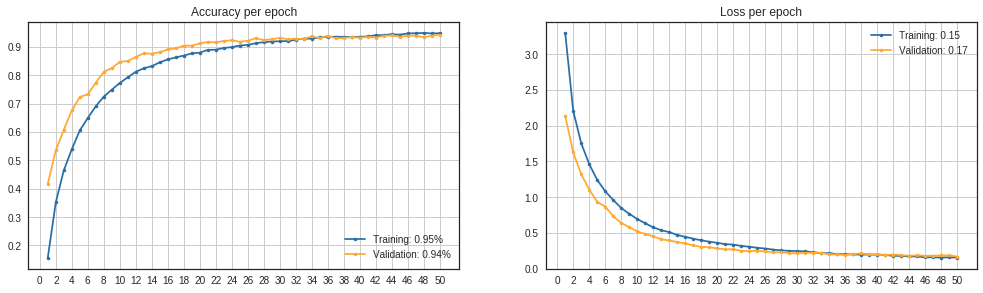

In [26]:
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(17, 10)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
positions = np.arange(1, EPOCHS+1)
xticks = np.arange(0, EPOCHS+1, 2)
ta, tl = history.history['acc'], history.history['loss']
va, vl = history.history['val_acc'], history.history['val_loss']

ax1.plot(positions, ta,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(ta[-1]))
ax1.plot(positions, va,".-", color='#FFA933', label="Validation: {0:.2f}%".format(va[-1]))
ax1.grid(True); ax1.legend(); ax1.set_title("Accuracy per epoch");
ax1.set_xticks(xticks)

ax2.plot(positions, tl, ".-", color='#2A6EA6', label="Training: {0:.2f}".format(tl[-1]))
ax2.plot(positions, vl,".-", color='#FFA933', label="Validation: {0:.2f}".format(vl[-1]))
ax2.grid(True); ax2.legend(); ax2.set_title("Loss per epoch")
ax2.set_xticks(xticks)

plt.show()

At first sight, it's curious that the validation metrics perform better. However:
* Regularization is turned off at testing time.
* Accuracy and loss are averaged over training time. At testing time, only the model state at the end is used.

Our final metrics on both training and validation set are the following.

In [38]:
model.evaluate(trainX, trainY)

42768/42768 [==============================] - 107s 3ms/step


[0.009674549791693627, 0.999883090160868]

In [39]:
model.evaluate(validX, validY)

4752/4752 [==============================] - 13s 3ms/step


[0.1694076214650464, 0.9427609427609428]

---
### 2.4 - Model Predictions
Lets use the model now to retrieve both the probabilities and the predicted classes on the validation set.

In [155]:
probabilities = model.predict(validX)
classes = np.argmax(probabilities, axis=1)

Now we can print some images with their true and predicted labels, as well as the probability distribution over the 99 classes.

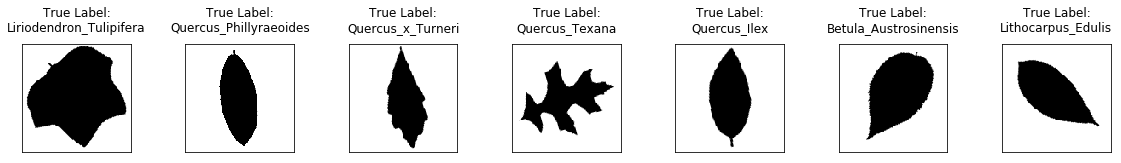

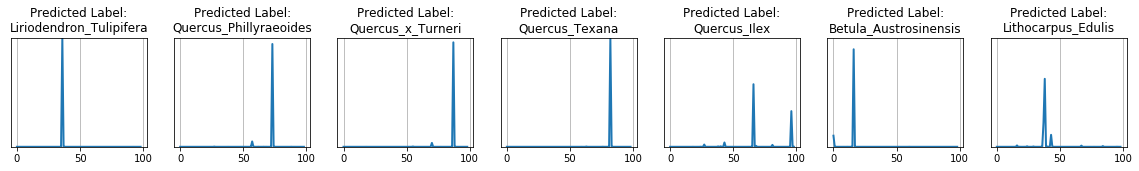

In [192]:
fig1, ax1 = plt.subplots(1, 7, figsize = (20, 2))
fig2, ax2 = plt.subplots(1, 7, figsize = (20, 2))
for t in range(7):
    x = np.random.randint(len(validY))
    ax1[t].matshow(validX.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
    ax1[t].set_title("True Label:\n{}".format(targetLabels[np.argmax(validY, axis=1)[x]]))

    ax1[t].get_yaxis().set_visible(False); ax1[t].get_xaxis().set_visible(False)
    ax2[t].plot(probabilities[x], lw=2)
    ax2[t].set_title("Predicted Label:\n{}".format(targetLabels[classes[x]]))
    ax2[t].get_yaxis().set_visible(False); ax2[t].set_ylim([0, 1]); ax2[t].grid(True)
plt.show()

More interesting are the wrongly predicted classes. We can see the probabilites for those being more uncertain as well.

In [193]:
falseMask = np.argmax(validY, axis=1) != classes
falseImages = validX[falseMask]
falseLabels = validY[falseMask]
falseProbabilities = probabilities[falseMask]
falseClasses = classes[falseMask]

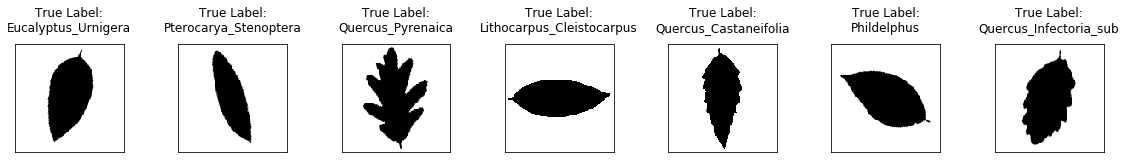

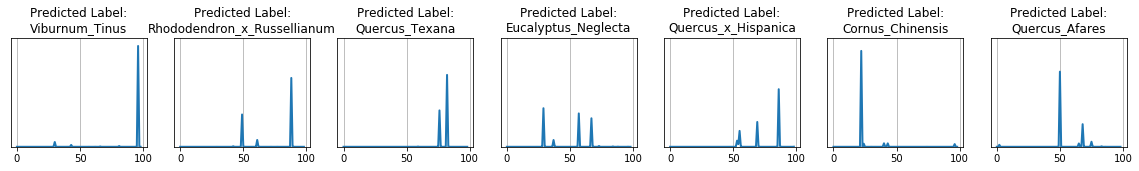

In [194]:
fig1, ax1 = plt.subplots(1, 7, figsize = (20, 2))
fig2, ax2 = plt.subplots(1, 7, figsize = (20, 2))
for t in range(7):
    x = np.random.randint(len(falseLabels))
    ax1[t].matshow(falseImages.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
    ax1[t].set_title("True Label:\n{}".format(targetLabels[np.argmax(falseLabels, axis=1)[x]]))

    ax1[t].get_yaxis().set_visible(False); ax1[t].get_xaxis().set_visible(False)
    ax2[t].plot(falseProbabilities[x], lw=2)
    ax2[t].set_title("Predicted Label:\n{}".format(targetLabels[falseClasses[x]]))
    ax2[t].get_yaxis().set_visible(False); ax2[t].set_ylim([0, 1]); ax2[t].grid(True)
plt.show()